# Importing all Libraries

In [591]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import time
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Data Manipulation

In [596]:
data = pd.read_csv("data.csv")
data.isnull().values.any()

True

In [597]:
data = data.dropna()

#### We want to transform the data to get the average price grouped by the day and to see usual datetime format (not a timestamp as above).

In [598]:
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
group = data.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64

In [599]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


#### We need to split our dataset because we want to train and test the model only on some chunk of the data. So, in the next cell, we are counting the necessary parameters for splitting (number of days between some dates). We want to train our model on the data from January 1, 2016 until August 21, 2017 and to test the model on the data from August 21, 2017 until October 20, 2017.

In [600]:


d0 = date(2016, 1, 1)
d1 = date(2017, 10, 15)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = date(2017, 8, 21)
d1 = date(2017, 10, 20)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2017, 10, 15)
d1 = date(2017, 10, 20)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

654
61
6


In [601]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

599 61


# Exploratory Data Analysis

#### We want to estimate some parameters of our data because this can be useful in the further model designing. The first important thing when forecasting time series is to check if the data is stationary. This means that our data is influenced by such factors as trend or seasonality.

#### In the next cell, we concatenate train and test data to make analysis and transformations simultaneously.
#### The motivation for the idea was drawn by me from a few blogs like: https://github.com/topics/bitcoin-price-prediction, https://medium.com/datadriveninvestor/predicting-cryptocurrency-prices-with-machine-learning-1b5a711d3937, https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4

In [602]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

#### In the next couple of cells, we perform seasonal decomposition of the data to estimate its trend and seasonality. You can see actual price movements on the plot below ("observed") as well as the trend and seasonality in our data.

In [603]:
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

#### The next thing we do is an examination of the autocorrelation. It is it is the similarity between observations as a function of the time lag between them. It is important for finding repeating patterns in the data.

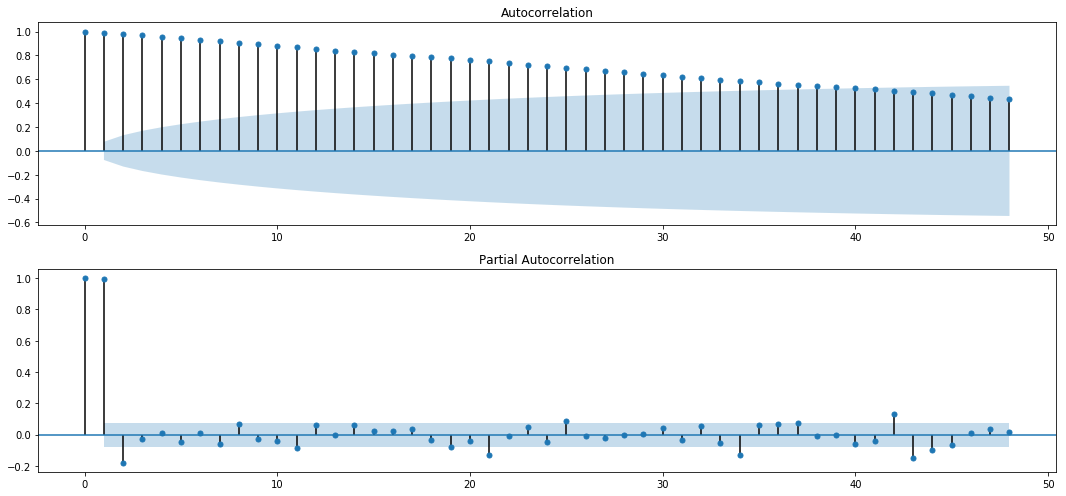

In [604]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

# Data preparation

#### We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of this values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1). 

In [605]:
df_train = working_data[:-60]
df_test = working_data[-60:]

In [606]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#### Now we perform final data preparation:

#### 1. Reshape the train and test set according to the requirements of the model.
#### 2. Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.
#### 3. Apply our create_lookback function.

In [607]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)


# reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Training

## 1. Deep Learning Model (RNN with LSTM)

In [608]:

# LSTM Model parameters, I chose
batch_size = 16            # Batch size (you may try different values)
epochs = 100               # Epoch (you may try different values)
seq_len = 30              # 30 sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'linear'     # Linear activation
input_shape=(None,1)      # Input dimension
output_dim = 30           # Output dimension

model_dl = Sequential()
model_dl.add(LSTM(units=output_dim, return_sequences=True, input_shape=input_shape))
model_dl.add(Dense(units=32,activation=activation))
model_dl.add(LSTM(units=output_dim, return_sequences=False))
model_dl.add(Dense(units=1,activation=activation))
model_dl.compile(optimizer=optimizer,loss=loss)



In [609]:
# Fitting Train Data

start_time = time.time()
end_time = time.time()
history = model_dl.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
processing_time = end_time - start_time

Train on 599 samples, validate on 59 samples
Epoch 1/100
599/599 [==============================] - 5s 8ms/step - loss: 0.0607 - val_loss: 0.0859
Epoch 2/100
599/599 [==============================] - 0s 296us/step - loss: 0.0245 - val_loss: 0.0637
Epoch 3/100
599/599 [==============================] - 0s 275us/step - loss: 0.0189 - val_loss: 0.0544
Epoch 4/100
599/599 [==============================] - 0s 235us/step - loss: 0.0149 - val_loss: 0.0434
Epoch 5/100
599/599 [==============================] - 0s 236us/step - loss: 0.0105 - val_loss: 0.0303
Epoch 6/100
599/599 [==============================] - 0s 231us/step - loss: 0.0063 - val_loss: 0.0160
Epoch 7/100
599/599 [==============================] - 0s 236us/step - loss: 0.0029 - val_loss: 0.0052
Epoch 8/100
599/599 [==============================] - 0s 235us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/100
599/599 [==============================] - 0s 231us/step - loss: 8.9092e-04 - val_loss: 0.0015
Epoch 10/100
599/599 [====

In [610]:
# Saving the model (just in case)
model_dl.save('coin_predictor.h5')

In [611]:
# Making predictions through trained model

pred_dl = model_dl.predict(X_test, batch_size=2)

### Performance Plot

In [612]:
prediction_inverse = scaler.inverse_transform(preds.reshape(-1, 1))
Y_list = Y_test.tolist()
Y_list.insert(0,0.346)
Y_test = np.array(Y_list)
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices Deep Learning model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

### Model Evaluation

In [613]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse[0:59], prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 87.150


In [614]:
abs_diff = abs(a - prediction2_inverse) / a
abs_percent_error = np.mean(abs_diff)*100
dl_ape = 100 - np.mean(abs_diff*100)

print('Absolute Percentage Error:  %.3f' %dl_ape)

Absolute Percentage Error:  99.227


In [615]:
r2 = r2_score(Y_test2_inverse[0:59], prediction2_inverse)
evs = explained_variance_score(Y_test2_inverse[0:59], prediction2_inverse) 

print('Coefficient of Determination: %.3f' %r2)
print('Explained Variance Score: %.3f' %evs)

Coefficient of Determination: 0.992
Explained Variance Score: 0.998


In [616]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

## 2. Boosting Model (XGBoost)

### Hyperparameter Tuning (not highly needed in this case)

In [617]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [618]:
xgb = XGBRegressor()

In [619]:
## TUNE ##

# xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

# xgb_grid.fit(x_train, y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [620]:
look_back = 1
x_train, y_train = create_lookback(training_set, look_back)
x_test, y_test = create_lookback(test_set, look_back)

# Training XGB
model = XGBRegressor()
model.fit(x_train, y_train)

[03:30:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [621]:
# Predicting through XGB

pred_xgb = model.predict(x_test)

### Performance Plot

In [622]:
prediction_inverse = scaler.inverse_transform(pred_xgb.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices XGBoost model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

### Model Evaluation

In [623]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse[0:58], prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 321.697


In [624]:
abs_diff = abs(Y_test2_inverse[0:58] - prediction2_inverse) / Y_test2_inverse[0:58]
abs_percent_error = np.mean(abs_diff)*100
xgb_ape = 100 - np.mean(abs_diff*100)

print('Absolute Percentage Error:  %.3f' %xgb_ape)

Absolute Percentage Error:  98.095


In [625]:
r2 = r2_score(Y_test2_inverse[0:58], prediction2_inverse)
evs = explained_variance_score(Y_test2_inverse[0:58], prediction2_inverse) 

print('Coefficient of Determination: %.3f' %r2)
print('Explained Variance Score: %.3f' %evs)

Coefficient of Determination: 0.892
Explained Variance Score: 0.893


## 3. Bagging Model (Random Forest)

In [626]:
## Fitting train data

rf = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
rf.fit(x_train, y_train) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [627]:
## Predicting through Random Forest

pred_rf = rf.predict(x_test)

### Performance Plot

In [628]:
prediction_inverse = scaler.inverse_transform(pred_rf.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices RandomForest model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

### Model Evaluation

In [629]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse[0:58], prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 802.672


In [630]:
abs_diff = abs(Y_test2_inverse[0:58] - prediction2_inverse) / Y_test2_inverse[0:58]
abs_percent_error = np.mean(abs_diff)*100
rf_ape = 100 - np.mean(abs_diff*100)

print('Absolute Percentage Error:  %.3f' %rf_ape)

Absolute Percentage Error:  93.690


In [631]:
r2 = r2_score(Y_test2_inverse[0:58], prediction2_inverse)
evs = explained_variance_score(Y_test2_inverse[0:58], prediction2_inverse) 

print('Coefficient of Determination: %.3f' %r2)
print('Explained Variance Score: %.3f' %evs)

Coefficient of Determination: 0.325
Explained Variance Score: 0.513


# Automated Signals

### Detrending Training labels

In [632]:
diff = list()
for i in range(1, len(y_train)):
    value = y_train[i] - y_train[i - 1]
    diff.append(value)

### Detrending Predicted labels

In [633]:
diff_test = list()
for i in range(1, len(pred_dl)):
    value = pred_dl[i] - pred_dl[i - 1]
    diff_test.append(value)

#### This is how detrended data looks like!

In [634]:
trace1 = go.Scatter(
    x = np.arange(0, len(diff), 1),
    y = diff,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1]
layout = dict(title = 'De-trended Values',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'De-trended Price (not to scale)'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

### Producing Signals

In [635]:
prediction_inverse = scaler.inverse_transform(preds.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [636]:
df = df_test[1:]

In [637]:
df['automated_signal'] = ['No Signal']*df.shape[0]
for i in range(df.shape[0]-2):
    if (float(diff_test[i+1]) >= float(diff_test[i]) + 1.5*sd):
        df['automated_signal'][i] = 'Buy (High Intensity)'
        
    elif (float(diff_test[i+1]) < float(diff_test[i]) + 1.5*sd) & (float(diff_test[i+1]) >= float(diff_test[i]) + 0.5*sd):
        df['automated_signal'][i] = 'Buy (Moderate Intensity)'
        
    elif (float(diff_test[i+1]) >= float(diff_test[i])) & (float(diff_test[i+1]) < float(diff_test[i]) + 0.5*sd):
        df['automated_signal'][i] = 'Buy (Low Intensity)'
        
    elif (float(diff_test[i+1]) <= float(diff_test[i]) - 1.5*sd):
        df['automated_signal'][i] = 'Sell (High Intensity)'
        
    elif (float(diff_test[i+1]) > float(diff_test[i]) - 1.5*sd) & (float(diff_test[i+1]) <= float(diff_test[i]) - 0.5*sd):
        df['automated_signal'][i] = 'Sell (Moderate Intensity)'
        
    elif (float(diff_test[i+1]) <= float(diff_test[i])) & (float(diff_test[i+1]) > float(diff_test[i]) - 0.5*sd):
        df['automated_signal'][i] = 'Sell (Low Intensity)'

In [638]:
df

,Weighted_Price,automated_signal
date,,
2019-06-15,8727.687036,Sell (Low Intensity)
2019-06-16,9095.289102,Sell (Moderate Intensity)
2019-06-17,9235.846433,Sell (Moderate Intensity)
2019-06-18,9152.500069,Buy (Low Intensity)
2019-06-19,9148.013959,Buy (Moderate Intensity)
2019-06-20,9353.226486,Buy (Moderate Intensity)
2019-06-21,9801.486018,Buy (Moderate Intensity)
2019-06-22,10724.805005,Sell (High Intensity)
2019-06-23,10746.900511,Buy (Low Intensity)


# Thank you so mcuh!